In [37]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
papers_and_authors = pd.read_csv('E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/papers_and_authors.csv')

In [3]:
papers_and_authors.head()

,year,title,event_type,pdf_name,abstract,paper_text,paper_id,author_id
0,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1
1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54


In [4]:
papers_and_authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20843 entries, 0 to 20842
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        20843 non-null  int64 
 1   title       20843 non-null  object
 2   event_type  8156 non-null   object
 3   pdf_name    20843 non-null  object
 4   abstract    20843 non-null  object
 5   paper_text  20843 non-null  object
 6   paper_id    20843 non-null  int64 
 7   author_id   20843 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 1.3+ MB


In [5]:
only_auth_title = papers_and_authors.drop(['year', 'event_type', 'pdf_name', 'abstract', 'paper_text', 'paper_id'], axis=1)
only_auth_title.head()

,title,author_id
0,Self-Organization of Associative Database and ...,1
1,Self-Organization of Associative Database and ...,2
2,A Mean Field Theory of Layer IV of Visual Cort...,14
3,Storing Covariance by the Associative Long-Ter...,155
4,Storing Covariance by the Associative Long-Ter...,54


In [6]:
def jordan_detector(row):
    if row['author_id'] == 330:
        return 1
    else:
        return 0

In [7]:
only_auth_title['is_jordan'] = only_auth_title.apply(lambda row: jordan_detector(row), axis=1)
only_auth_title.head()

,title,author_id,is_jordan
0,Self-Organization of Associative Database and ...,1,0
1,Self-Organization of Associative Database and ...,2,0
2,A Mean Field Theory of Layer IV of Visual Cort...,14,0
3,Storing Covariance by the Associative Long-Ter...,155,0
4,Storing Covariance by the Associative Long-Ter...,54,0


In [8]:
len(only_auth_title.query('author_id == 330'))

79

In [9]:
is_jordan = only_auth_title.drop('author_id', axis=1)
is_jordan.sort_values(by='is_jordan', ascending=False, inplace=True)
is_jordan.drop_duplicates(subset='title', inplace=True)
len(is_jordan)

7241

In [10]:
len(is_jordan.query('is_jordan == 1'))

79

In [27]:
is_jordan.is_jordan.value_counts(normalize=True)

0    0.98909
1    0.01091
Name: is_jordan, dtype: float64

In [11]:
X = is_jordan['title'].to_frame()
y = is_jordan['is_jordan'].to_frame()


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, train_size=0.75)

In [13]:
X_train

,title
15264,Parallelizing MCMC with Random Partition Trees
9495,Recovering Intrinsic Images with a Global Spar...
18289,A graph-theoretic approach to multitasking
1026,Instabilities in Eye Movement Control: A Model...
13361,Asynchronous Anytime Sequential Monte Carlo
...,...
9014,Tree-Structured Stick Breaking for Hierarchica...
14454,Interactive Control of Diverse Complex Charact...
10083,Algorithms for Hyper-Parameter Optimization
1863,Low Power Wireless Communication via Reinforce...


In [14]:
tfidf = TfidfVectorizer()

In [15]:
X_train = tfidf.fit_transform(X_train.title)

In [16]:
X_train.shape

(5430, 4854)

In [17]:
X_train_array = X_train.toarray()
df_X_train = pd.DataFrame(X_train_array, columns=tfidf.get_feature_names_out())
df_X_train.describe()

,000,1993,1d,25,2d,360,3d,3n2,40,5d,...,young,your,zag,zap,zero,zeroth,zeta,zig,zip,zype
count,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,...,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000
mean,0.000076,0.000067,0.000069,0.000073,0.000540,0.000087,0.001820,0.000079,0.000055,0.000083,...,0.000068,0.000215,0.000087,0.000177,0.000531,0.000065,0.000159,0.000087,0.000079,0.000078
std,0.005578,0.004938,0.005103,0.005361,0.015122,0.006385,0.026184,0.005816,0.004041,0.006111,...,0.004976,0.009418,0.006424,0.013042,0.014882,0.004810,0.008277,0.006424,0.005850,0.005726
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.411016,0.363875,0.376044,0.395056,0.476690,0.470529,0.520284,0.428568,0.297751,0.450327,...,0.366642,0.515761,0.473408,0.961032,0.470466,0.354411,0.443900,0.473408,0.431109,0.421914


In [18]:
X_test = tfidf.transform(X_test.title)
X_test.shape

(1811, 4854)

In [19]:
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

In [20]:
lr = LogisticRegression(random_state=21)

In [21]:
lr.fit(X_train, y_train)

LogisticRegression()

In [22]:
predictions = lr.predict(X_test)

In [34]:
accuracy = lr.score(X_test, y_test)
auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
print('Accuracy:', accuracy)
print('AUC:', auc)
print('Recall score:', recall)

Accuracy: 0.9895085588072888
AUC: 0.5
Recall score: 0.0


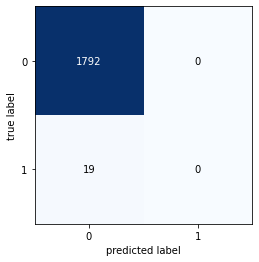

In [26]:
cm = confusion_matrix(y_test, predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [30]:
weights = {0:1, 1:99}
lr2 = LogisticRegression(random_state=21, class_weight=weights)
lr2.fit(X_train, y_train)
predictions2 = lr2.predict(X_test)

In [35]:
accuracy2 = lr2.score(X_test, y_test)
auc2 = roc_auc_score(y_test, predictions2)
recall2 = recall_score(y_test, predictions2)
print('Accuracy:', accuracy2)
print('AUC:', auc2)
print('Recall score:', recall2)

Accuracy: 0.9685256764218664
AUC: 0.5675076362781956
Recall score: 0.15789473684210525


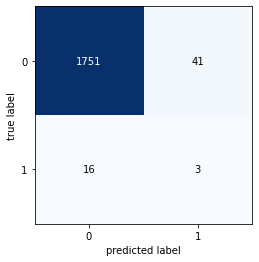

In [36]:
cm2 = confusion_matrix(y_test, predictions2)
fig, ax = plot_confusion_matrix(conf_mat=cm2)
plt.show()

In [ ]:
oversample = RandomOverSampler(random_state=21)

